# Winter Data
Coastal Endurance - Oregon Shelf Surface Piercing Profiler Mooring

17 Dec 2018 00:00:00 to 18 Dec 2018 00:00:00 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import requests
import datetime

In [2]:
data = pd.read_csv("coastal_endurance_OOCSPM.csv")
data.head()

,obs,conductivity,corrected_dissolved_oxygen,corrected_dissolved_oxygen_qc_executed,corrected_dissolved_oxygen_qc_results,density,density_qc_executed,density_qc_results,deployment,driver_timestamp,...,seawater_conductivity_qc_executed,seawater_conductivity_qc_results,seawater_pressure,seawater_pressure_qc_executed,seawater_pressure_qc_results,seawater_temperature,seawater_temperature_qc_executed,seawater_temperature_qc_results,temperature,time
0,"('0',)",1445803,138.988666,29,29,1027.182891,29,13,5,3.753994e+09,...,29,13,194.648900,29,29,8.604672,29,29,432267,3.753994e+09
1,"('1',)",1445802,138.967438,29,29,1027.183192,29,13,5,3.753994e+09,...,29,13,194.678774,29,29,8.604421,29,29,432271,3.753994e+09
2,"('2',)",1445798,138.912851,29,29,1027.183375,29,13,5,3.753994e+09,...,29,13,194.704421,29,29,8.604107,29,29,432276,3.753994e+09
3,"('3',)",1445796,138.959882,29,29,1027.184004,29,13,5,3.753994e+09,...,29,13,194.730053,29,29,8.603416,29,29,432287,3.753994e+09
4,"('4',)",1445800,138.937795,29,29,1027.184353,29,13,5,3.753994e+09,...,29,13,194.763146,29,29,8.603416,29,29,432287,3.753994e+09


In [3]:
data.shape

(86398, 33)

In [4]:
#Defining parameters
ABDP_time = data.ingestion_timestamp
pres = data.seawater_pressure #same as depth as dbar is one to one to meters
sal = data.practical_salinity
T = data.seawater_temperature

C:\Users\ctaing\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737045.   , 737045.125, 737045.25 , 737045.375, 737045.5  ,
        737045.625, 737045.75 , 737045.875, 737046.   ]),
 <a list of 9 Text xticklabel objects>)

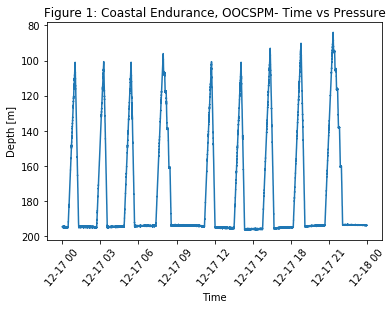

In [5]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
#defines ntp_timezone and disregarding 70 yr offset

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

time7=[]
for i in range(len(ABDP_time)):
    time7.append(ntp_seconds_to_datetime(ABDP_time[i]))
    
plt.plot(time7,pres)
plt.gca().invert_yaxis() #Code to reverse depth
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title('Figure 1: Coastal Endurance, OOCSPM- Time vs Pressure')
plt.xticks(rotation=50)


In [6]:
#Using data referenced from Matthew on 1/29/2020
def total_dives(pres):
    minimum_depth =max(pres)
    maximum_depth = False
    divecount = 0
    
    for i in range(0,len(pres)):
        if(pres[i]>0.95*minimum_depth and not maximum_depth):
            maximum_depth = True
        
        if(pres[i]<0.95*minimum_depth and maximum_depth):
            maximum_depth = False
            divecount +=1
    return divecount

print("Total dives within 24 hours of Oregon Shelf Surface Piercing Profiler Mooring is = ",total_dives(pres))

Total dives within 24 hours of Oregon Shelf Surface Piercing Profiler Mooring is =  11


In [7]:
#Defining speed of sound
c =1449.2+4.6*(T)-0.055*(T)**2+0.00029*T**3+(1.34-.01*T)*(sal-35)+0.016*pres
c_max = max(c)
print("Maximum speed of sound is ", c_max, "m/s")


Maximum speed of sound is  1489.4139857610037 m/s


Text(0.5, 1.0, 'Figure 2: Coastal Endurance, OSSPPM - Pressure (dbar) vs SSP')

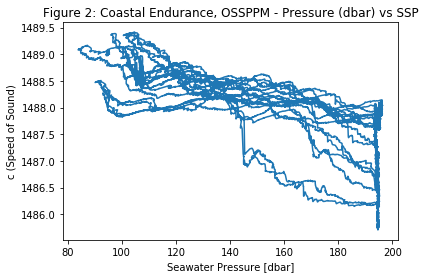

In [8]:
plt.plot(pres , c)
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 2: Coastal Endurance, OSSPPM - Pressure (dbar) vs SSP')


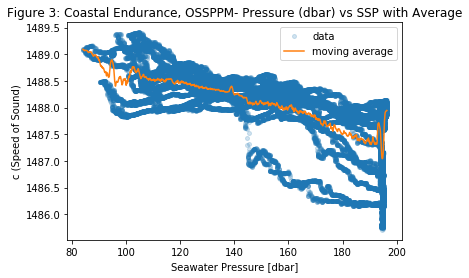

In [9]:
#define a moving average function
plt.plot(pres,c,'o',alpha=0.2,ms=4,label='data')
def moving_average(pres,c,step_size=0.1,bin_size=1):
    bin_centers = np.arange(np.min(pres),np.max(pres)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))
    
    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        items_in_bin = c[(pres>(bin_center-bin_size*0.5) ) & (pres<(bin_center+bin_size*0.5))]
        bin_avg[index] = np.mean(items_in_bin)
    return bin_centers,bin_avg

#plot the moving average
bins, average = moving_average(pres,c)
plt.plot(bins, average,label='moving average')
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 3: Coastal Endurance, OSSPPM- Pressure (dbar) vs SSP with Average')
plt.legend()
plt.show()

#Please wait a moment, takes a lil while to publish for slower computers